In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import random
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import random
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, ScalarFormatter)
import networkx as nx
from scipy.stats import bernoulli
import sounddevice as sd

In [2]:
D = 1e3
P = 1e3
L = 1e3
r = 250
d_max = 1200
BS = [P/2, L/2, 0]

N = 48
f = 4e4
pH = 7.82      
sh = 0.8
T = 4.11
S = 34.31
w = 6
k = 1.5
spreading_factor = 2
m = 10

kc = 1
kd = 2500
kt = kd + N
beta = 0.8
data_rate = 500 # bps
t_transmission =  ((kd * 8)/data_rate) + ((kc * 8)/data_rate) + (((kc + N) * 8)/data_rate)
initial_energy = 1
E_elec = 50 * 1e-9
P_tx = 1e-3
p = 0.05

In [3]:
def generate_sound(frequency, duration, sample_rate=44100):
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    audio = np.sin(2 * np.pi * frequency * t)
    return audio

def play_sound(sound, sample_rate=44100):
    sd.play(sound, samplerate=sample_rate)
    sd.wait()

# Set the frequency and duration of the sound
desired_frequency = 880  # Change this to your desired frequency in Hz
desired_duration = 1      # Change this to your desired duration in seconds

# Generate the sound
sound = generate_sound(desired_frequency, desired_duration)



In [4]:
class bernoulli():
    def pmf(x,p):
        """
        probability mass function        
        """
        f = p**x*(1-p)**(1-x)
        return f
    
    def mean(p):
        """
        expected value of bernoulli random variable
        """
        return p
    
    def var(p):
        """
        variance of bernoulli random variable
        """
        return p*(1-p)
    
    def std(p):
        """
        standart deviation of bernoulli random variable
        """
        return bernoulli.var(p)**(1/2)
    
    def rvs(p,size=1):
        """
        random variates
        """
        rvs = np.array([])
        for i in range(0,size):
            if np.random.rand() <= p:
                a=1
                rvs = np.append(rvs,a)
            else:
                a=0
                rvs = np.append(rvs,a)
        return rvs

In [5]:
bernoulli.rvs(0.8,size=5)

array([1., 0., 1., 0., 1.])

In [6]:
def vibrationFrequencies(show_info = False):
    f1 = 0.78 * np.sqrt(S/35) * np.exp(T/26)
    f2 = 42 * np.exp(T/17)

    if show_info: 
        print(f"F1 : {f1:.2f} | f2 : {f2:.2f}")

    return f1, f2

f1, f2 = vibrationFrequencies(show_info = True)
def attenuationConstant(D, f_kHz, show_info = False, formula="anslie"):
    D_km = D/1e3
    f1_kHz = f1/1e3
    f2_kHz = f2/1e3

    
    if formula=="anslie":
        term1 = 0.106 * (f1_kHz * (f_kHz**2)) / (f1_kHz**2 + f_kHz**2) * np.exp((pH - S) / 0.56)
        term2 = 0.52 * (1 + (T / 43)) * (S / 35) * ( (f2_kHz * (f_kHz**2)) / ((f2_kHz**2) + (f_kHz**2)) ) * np.exp(-D_km / 6)
        term3 = 4.9e-4 * (f_kHz**2) * np.exp(-((T / 27) + (D_km / 17)))
        attenuation = term1 + term2 + term3
        
    elif formula=="thorp":
        attenuation = 0.11 * ((f_kHz**2) / (1 + (f_kHz**2))) + 44 * ((f_kHz**2) / (4100 + (f_kHz**2))) + 2.75e-4 * (f_kHz**2) + 0.003

    if show_info: 
        print(f"attenuation constant: {attenuation:.2f}")

    return attenuation

def attenuation_dB(D, distance, f_kHz=f,  show_info = False, formula="anslie"):
    distance = distance/1e3
    att = k * 10 * np.log10(distance) + distance * attenuationConstant(D, f_kHz, show_info = False, formula=formula)
    # print(f"{k * 10 * np.log10(distance) } | {distance * attenuationConstant(D, f_kHz, show_info = False, formula=formula)}")
    # att = (distance**k) * (attenuationConstant(D, f_kHz, show_info = False, formula=formula)**distance)
    # att = 10 * np.log10(att)

    # print(f"att1 : {att1} | att2 : {att2}")
    if show_info:   
        print(f"Attenuation at distance ({distance:.2f} m) : {att:.2f} dB")
    return att

def attenuation(D, distance, freq = f, show_info = False, formula="anslie"):
    distance = distance/1e3
    att_constant = attenuationConstant(D, freq, show_info = False, formula=formula)
    att = (distance**spreading_factor) * (att_constant**distance)
    if show_info:   
        print(f"Attenuation at distance ({distance:.2f} m) | distance**spreading_factor: {distance**spreading_factor} |Att {att:.2f} | Att constant : {att_constant:.2f}")

    return att

def noise(f, sh, w, show_info = False):
    f_khz = f / 1e3
    turbulence_noise    =  17 - 30 * np.log10(f_khz)
    ship_noise          =  40 + 20 * (sh - 0.5) + 26 * np.log10(f_khz) - 60 * np.log10(f_khz + 0.03)
    wind_noise          =  50 + 7.5 * np.sqrt(w) + 20 * np.log10(f_khz) - 40 * np.log10(f_khz + 0.4)
    thermal_noise       =  -15 + 20 * np.log10(f_khz)

    noise_total = 10**(thermal_noise/10) + 10**(turbulence_noise/10) + 10**(wind_noise/10) + 10**(ship_noise/10)
    noise_total = 10 * np.log10(noise_total)

    if show_info:   
        turbulence_noise    = round(turbulence_noise    , 2)
        ship_noise          = round(ship_noise          , 2)
        wind_noise          = round(wind_noise          , 2)
        thermal_noise       = round(thermal_noise       , 2)
        noise_total         = round(noise_total       , 2)
        print(f"Noise total : {noise_total} | Thermal noise : {thermal_noise} | Ship noise : {ship_noise} | Wind noise : {wind_noise} | Turbulence noise : {turbulence_noise} | f : {f_khz * 1000} Hz")
    return noise_total

def thermal_noise(f_khz):
    return -15 + 20 * np.log10(f_khz)

def ship_noise(f_khz, sh):
    return 40 + 20 * (sh - 0.5) + 26 * np.log10(f_khz) - 60 * np.log10(f_khz + 0.03)

def wind_noise(f_khz, w):
    return 50 + 7.5 * np.sqrt(w) + 20 * np.log10(f_khz) - 40 * np.log10(f_khz + 0.4)

def turbulence_noise(f_khz):
    return 17 - 30 * np.log10(f_khz)

def underwater_speed(D, show_info = False):
    D_km = D/1e3
    v_uw = 1448.96 + 4.591 * T - 5.304e-2 * T**2 + 2.374 * T**3 + 1.340 * (S - 35) + \
           1.630e-2 * D_km + 1.675e-7 * D_km**2 - 1.025e-2 * T * (S - 35) - 7.139e-13 * D_km**3 * T
    
    if show_info:
        print(f"Underwater speed at D = {D:.2f} is : {v_uw:.2f} m/s")

    return v_uw

def ratio_delay(D, distance, data_rate, ideal=False):
    v_uw = underwater_speed(D, show_info = False)
    t_uw = distance/v_uw
    t_transmission =  ((kd * 8)/data_rate) + ((kc * 8)/data_rate) + (((kc + N) * 8)/data_rate)
    if ideal:
        t = distance/3e8
        a = t/t_transmission
        # print(f"ratio ideal : {a}")
        return t

    a = t_uw/t_transmission
    # print(f"Ratio delay : {a:.2f}  | v_uw : {v_uw} | T_tranmission : {t_transmission:.2f} | T_uw : {t_uw:.2f}")
    return a

def throughput(a, protocol="non-persistent", kc=kc):
    if protocol == "non-persistent":
        numerator = kc * np.exp(-a * kc)
        denominator = kc * (1 + 2 * a) + np.exp(-a * kc)
        rho = numerator / denominator
    elif protocol == "1-persistent":
        numerator = kc * (1 + kc + a*kc*(1+kc+(a*kc/2))) * np.exp(-kc * (1+(2*a)))
        denominator = kc * (1 + 2 * a) - (1-np.exp(-kc * a)) + (1 + a*kc) * np.exp(-kc * (1+a))
        rho = numerator / denominator
    elif protocol == "aloha":
        rho = kc*np.exp(-2*kc)
    elif protocol == "slotted-aloha":
        rho = kc*np.exp(-kc)
    # print(f"a : {a:.3f} | Throughput : {rho:.3f} | protocol : {protocol} | G : {kc}")
    return rho

def SNR(Ps, d, f):
    snr = []
    for P in Ps:   
        n_th = thermal_noise(f)
        n_t = turbulence_noise(f)
        n_w = wind_noise(f, 6)
        n_s = ship_noise(f, 0.8)
        P = 10**(P/10)
        n_total = 10**(n_th/10) + 10**(n_t/10) + 10**(n_w/10) + 10**(n_s/10)


        snr.append( 10 * np.log10(1/(P * n_total * attenuation(1000, d, f))))
    return snr

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

F1 : 0.90 | f2 : 53.49


In [7]:
attenuation_dB(5000, 1001,  f)

502235.27753334446

# Atenuasi

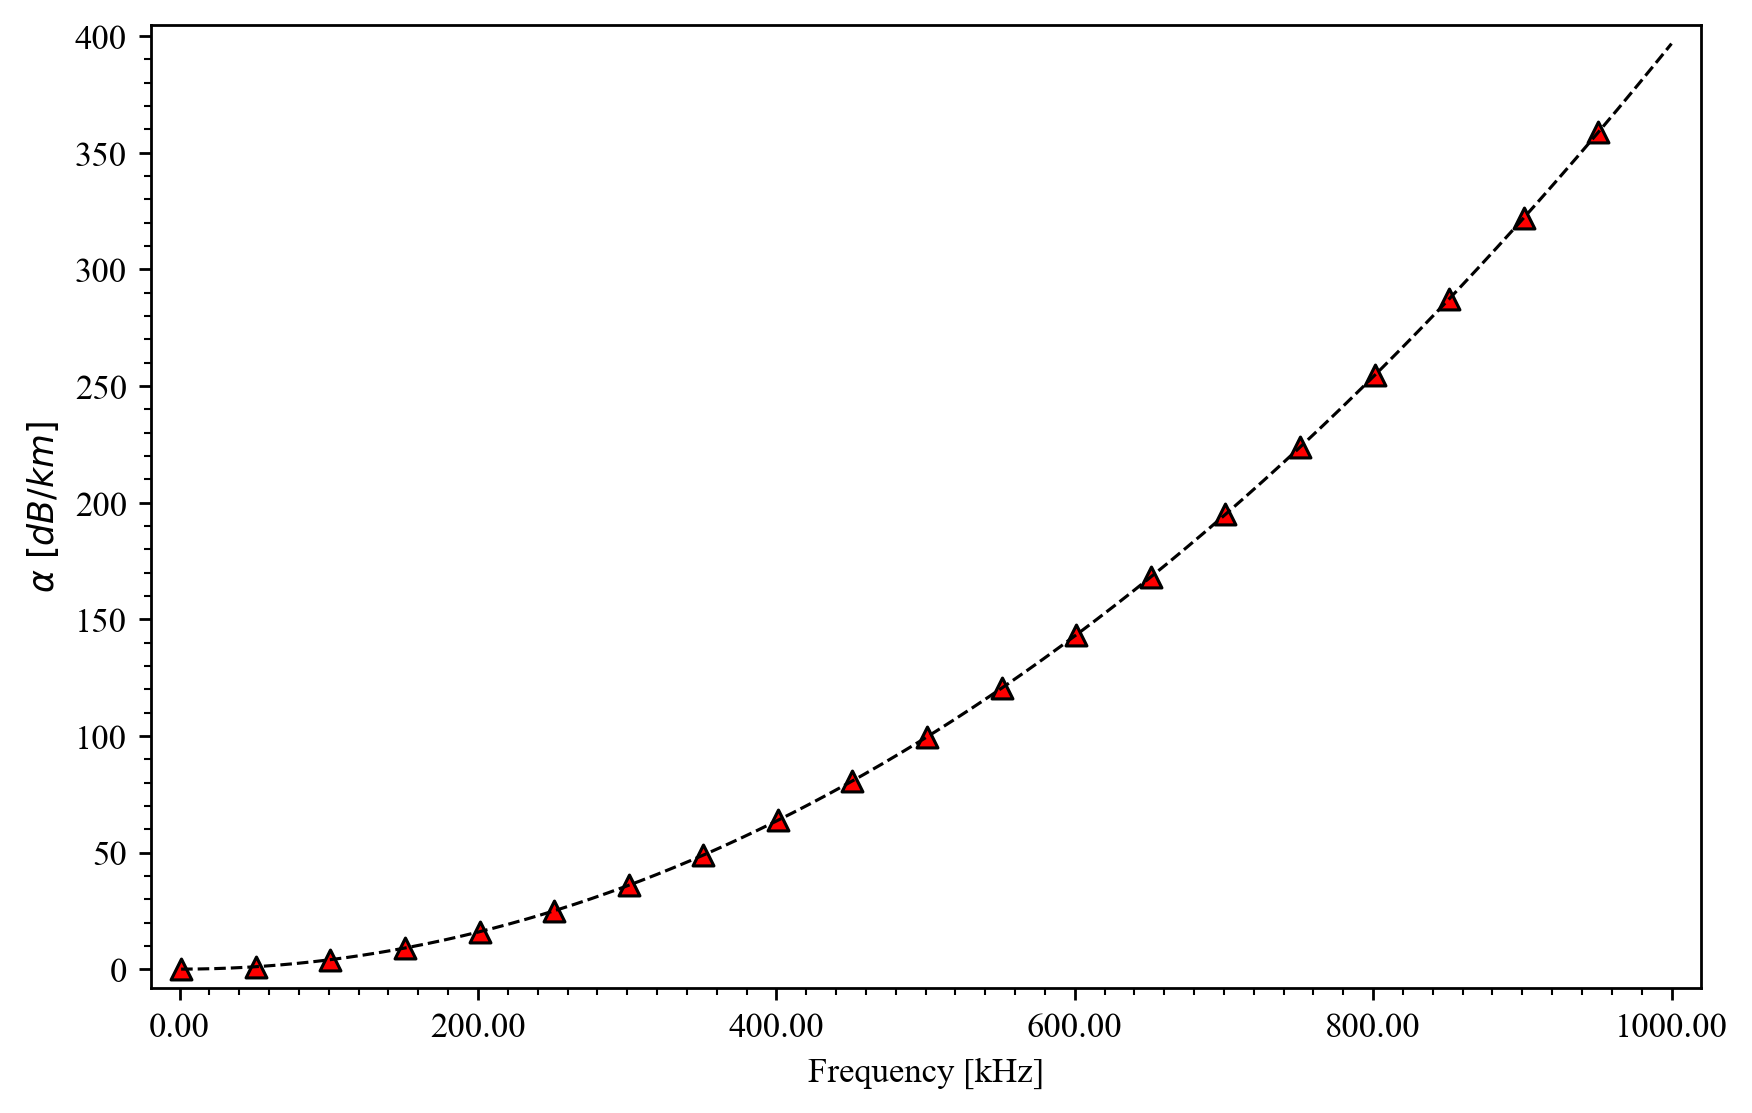

att min : 0.02560973780441575 | att max : 396.79642452532613


In [8]:
frequencies = [i for i in range(1, 1001, 1)]
att_data = []
att_data_thorp = []
for f in frequencies:
    att_data.append(attenuationConstant(1000, f))
    att_data_thorp.append(attenuationConstant(1000, f, formula="thorp"))


fig, ax = plt.subplots(figsize=(8,5), dpi=250)

hop = 50

ax.plot(frequencies          , att_data          , linestyle="--", color='k',     linewidth=0.9)
ax.scatter(frequencies[::hop], att_data[::hop]                       , color='r',     linewidth=0.9, label="Anslie", edgecolor='k', marker='^')
# ax.plot(frequencies          , att_data_thorp          , linestyle="--", color='k',     linewidth=0.9)
# ax.scatter(frequencies[::hop], att_data_thorp[::hop]                 , color='b',     linewidth=0.9, label="Thorp", edgecolor='k', marker='o')
ax.set_ylabel(r"$\alpha \,\, [dB/km]$")
ax.set_xlabel(r"Frequency [kHz]")
# ax.set_title(r"Protocol Comparison with $\zeta_{uw}=0.015$ and $\zeta_{c}=3.33 \times 10^{-6}$")

ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(200))
ax.xaxis.set_major_formatter('{x:.2f}')
ax.xaxis.set_minor_locator(MultipleLocator(20))

# ax.set_ylim([1600, 1640])    
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),fancybox=True, shadow=True, ncol=3, markerscale=1.2, fontsize=10)
# ax.grid(which='minor')
# ax.grid(which='major')
ax.margins(x=0.02, y=0.02)

ax.set_axisbelow(True)
plt.show()
print(f"att min : {att_data[0]} | att max : {att_data[len(att_data)-1]}")


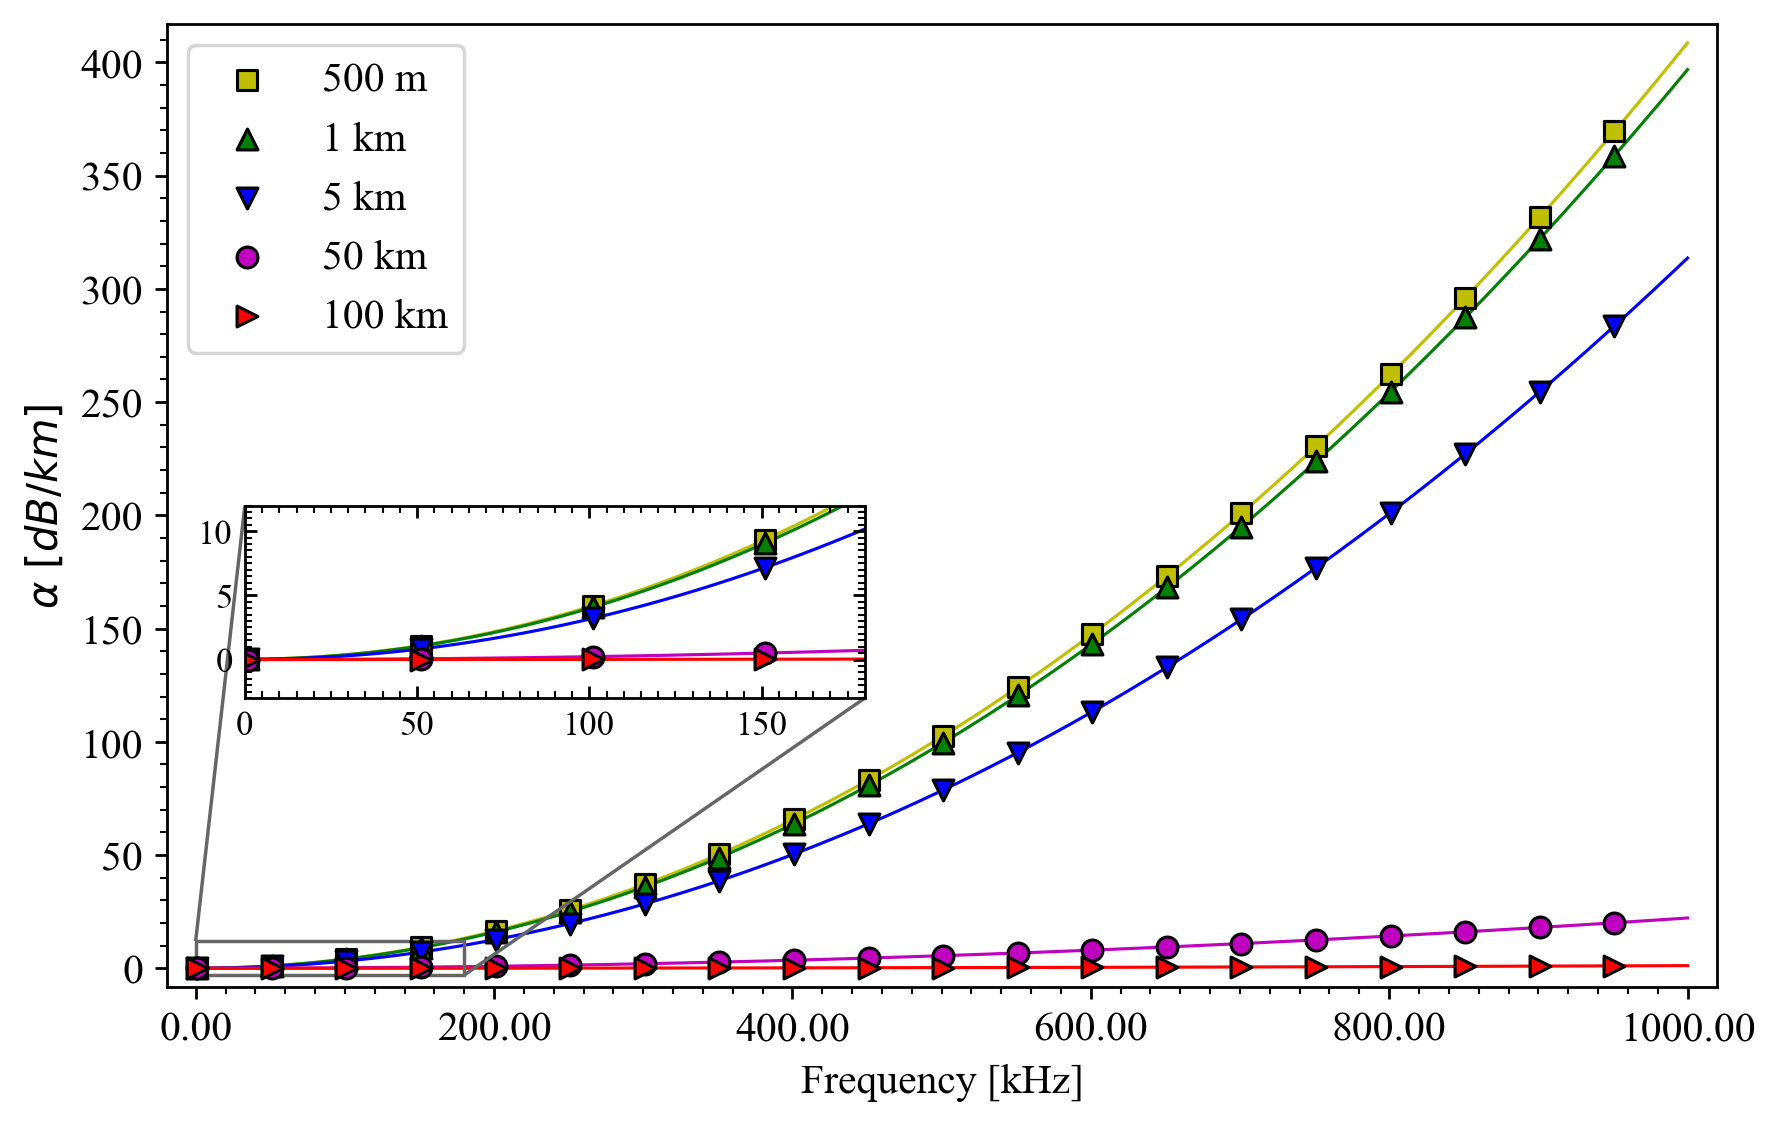

In [9]:
frequencies = [i for i in range(1, 1001, 1)]
labels = ['500 m', '1 km', '5 km', '50 km', '100 km']
values = [500, 1000, 5000, 50000, 100000]

colors = ['y', 'g', 'b', 'm', 'r', 'k', 'navy', 'maroon']
markers = ['s', '^', 'v', 'o', '>', '<', 'X', 'D']
FONTSIZE = 12
att_data = {}

count = 0
for label in labels:
    att_data[label] = []
    for f in frequencies:
        att_data[label].append(
            attenuationConstant(
                values[count], 
                f
            )
        )
    count += 1



fig, ax = plt.subplots(figsize=(8,5), dpi=250)

hop = 50


count = 0
for label in labels:
    ax.plot(frequencies          , att_data[label]          , linestyle="solid", color=colors[count],     linewidth=0.9, zorder=1)
    ax.scatter(frequencies[::hop], att_data[label][::hop]                   , color=colors[count],     linewidth=0.9, label=labels[count], edgecolor='k', marker=markers[count], zorder=2)

    count += 1

# ax.plot(frequencies          , att_data_thorp          , linestyle="--", color='k',     linewidth=0.9)
# ax.scatter(frequencies[::hop], att_data_thorp[::hop]                 , color='b',     linewidth=0.9, label="Thorp", edgecolor='k', marker='o')
ax.set_ylabel(r"$\alpha \,\, [dB/km]$", fontsize=FONTSIZE)
ax.set_xlabel(r"Frequency [kHz]", fontsize=FONTSIZE)
# ax.set_title(r"Protocol Comparison with $\zeta_{uw}=0.015$ and $\zeta_{c}=3.33 \times 10^{-6}$")
ax.xaxis.set_tick_params(labelsize=FONTSIZE)
ax.yaxis.set_tick_params(labelsize=FONTSIZE)
ax.legend(fontsize=FONTSIZE)

ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(200))
ax.xaxis.set_major_formatter('{x:.2f}')
ax.xaxis.set_minor_locator(MultipleLocator(20))

# ax.set_ylim([1600, 1640])    
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),fancybox=True, shadow=True, ncol=3, markerscale=1.2, fontsize=10)
# ax.grid(which='minor')
# ax.grid(which='major')
ax.margins(x=0.02, y=0.02)

ax.set_axisbelow(True)


ax_zoom = ax.inset_axes([0.05, 0.3, 0.4, 0.2]) 
mark_inset(ax, ax_zoom, loc1=2, loc2=4, fc="none", ec="0.4")
ax_zoom.set_ylim(-3, 12)
ax_zoom.set_xlim(0, 180)
ax_zoom.yaxis.set_major_locator(MultipleLocator(5))
ax_zoom.yaxis.set_minor_locator(MultipleLocator(0.5))
ax_zoom.xaxis.set_major_locator(MultipleLocator(50))
ax_zoom.xaxis.set_major_formatter('{x:.0f}')
ax_zoom.xaxis.set_minor_locator(MultipleLocator(5))
ax_zoom.tick_params(top=True, right=True, which='both', direction='in')

count = 0
for label in labels:
    ax_zoom.plot(frequencies          , att_data[label]          , linestyle="solid", color=colors[count],     linewidth=0.9, zorder=1)
    ax_zoom.scatter(frequencies[::hop], att_data[label][::hop]                   , color=colors[count],     linewidth=0.9, label=labels[count], edgecolor='k', marker=markers[count], zorder=2)

    count += 1


plt.show()

# Noise

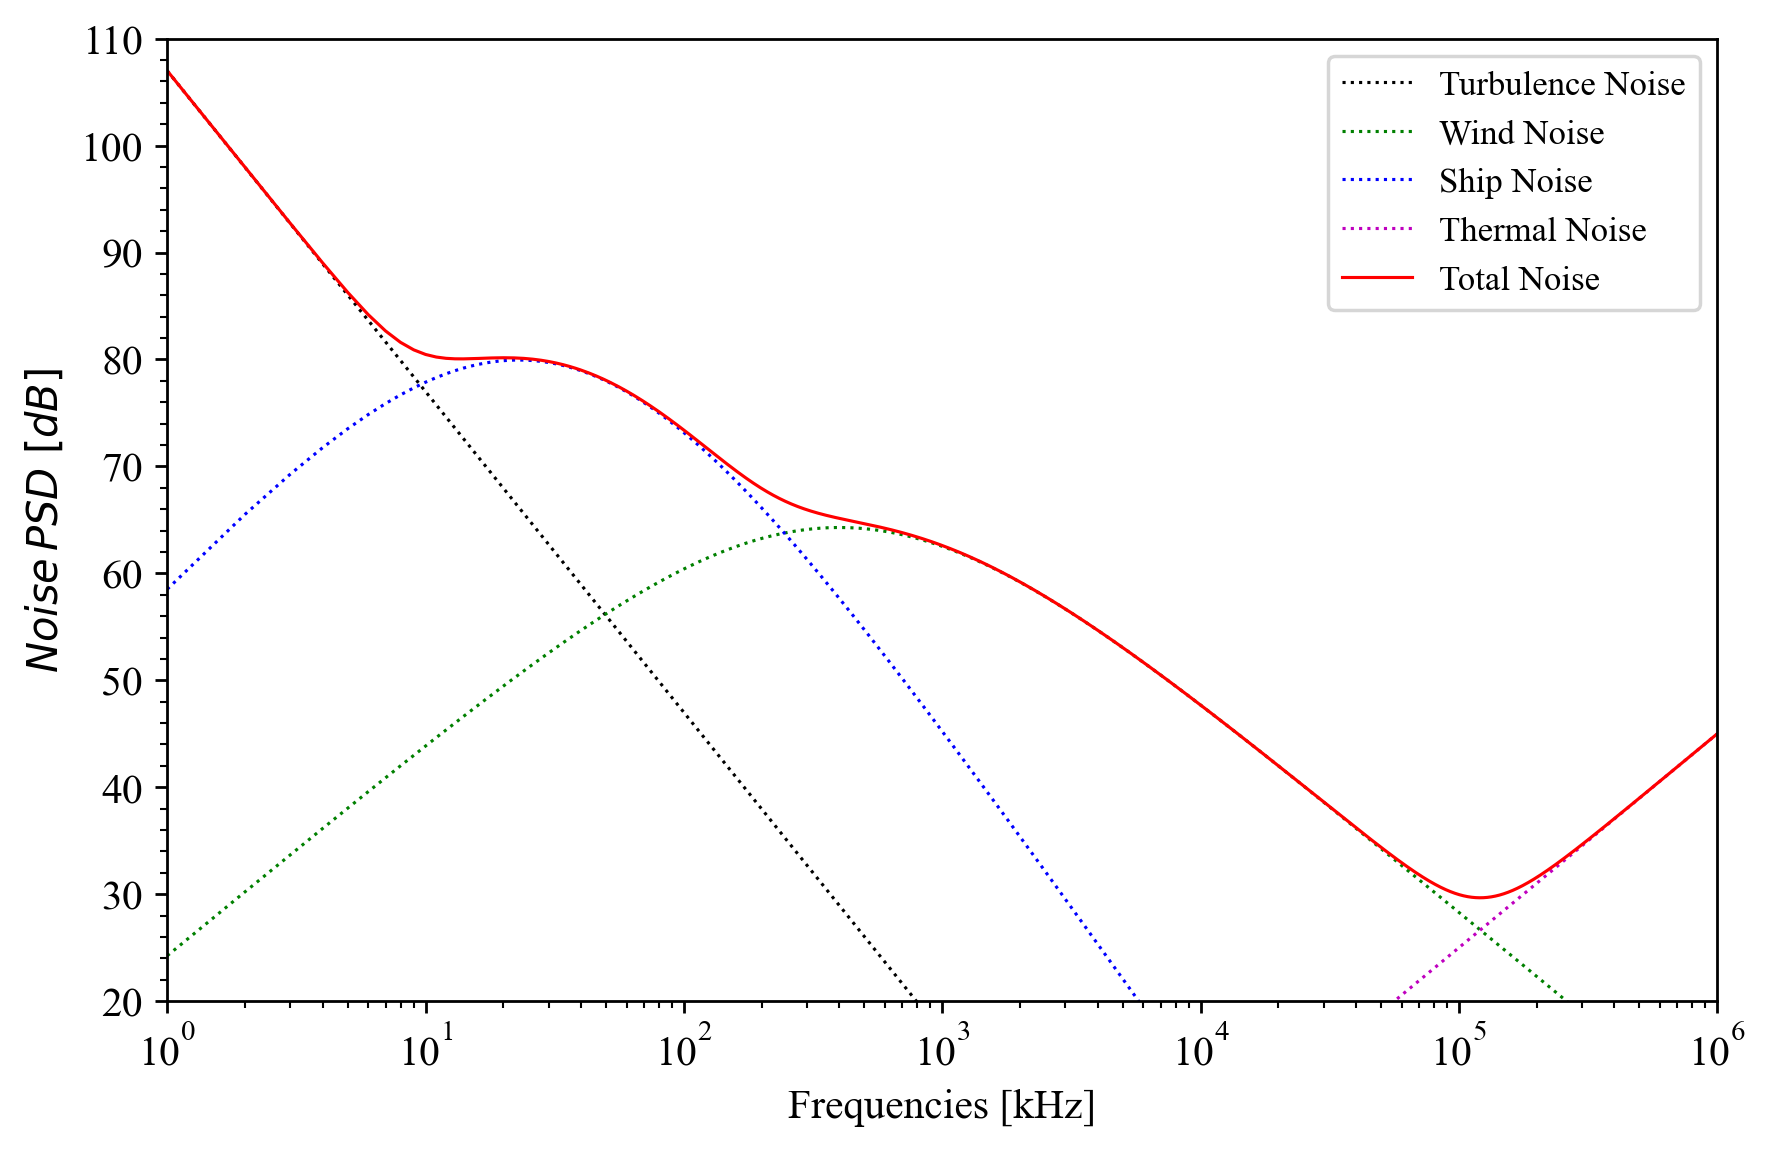

In [10]:
frequencies = np.arange(1, 1000001, 1)
noise_wind_10 = []
noise_wind_0_sh_0 = []
noise_wind_0_sh_05 = []
noise_wind_0_sh_1 = []

turbulence_noise_data = []
thermal_noise_data = []
wind_noise_data = []
ship_noise_data = []
total_noise_data = []

for f in frequencies:
    f = f/1e3
    n_th = thermal_noise(f)
    n_t = turbulence_noise(f)
    n_w = wind_noise(f, w)
    n_s = ship_noise(f, sh)
    n_total = 10**(n_th/10) + 10**(n_t/10) + 10**(n_w/10) + 10**(n_s/10)
    n_total = 10 * np.log10(n_total)

    thermal_noise_data.append(n_th)
    turbulence_noise_data.append(n_t)
    wind_noise_data.append(n_w)
    ship_noise_data.append(n_s)
    total_noise_data.append(n_total)


fig, ax = plt.subplots(figsize=(8,5), dpi=250)

hop = 10000
colors = ['k', 'g', 'b', 'm', 'r', 'k', 'navy', 'maroon']
markers = ['s', '^', 'v', 'o', '>', '<', 'X', 'D']
linestyles = ['dotted', 'dotted', 'dotted', 'dotted', 'solid', '<', 'X', 'D']
data = [noise_wind_10, noise_wind_0_sh_0, noise_wind_0_sh_05, noise_wind_0_sh_1]

data_noise = [turbulence_noise_data, wind_noise_data, ship_noise_data, thermal_noise_data, total_noise_data]
labels = ['Wind at 10 m/s', 'Wind at 0 m/s and shiping activity at 0', 'Wind at 0 m/s and shiping activity at 0.5' , 'Wind at 0 m/s and shiping activity at 1']
labels2 = ['Turbulence Noise', 'Wind Noise', 'Ship Noise', 'Thermal Noise', 'Total Noise']

count = 0
hop = 500
for i in data_noise:
    ax.plot(frequencies          , data_noise[count]          , linestyle=linestyles[count] , color=colors[count],     linewidth=0.9, label=labels2[count])
    count += 1

ax.set_ylabel(r"$Noise \, PSD \,\, [dB]$", fontsize=FONTSIZE)
ax.set_xlabel(r"Frequencies [kHz]", fontsize=FONTSIZE)
ax.set_ylim([20, 110])
# ax.axvline(x=38.51, linestyle='dashdot', color='k', linewidth=0.5)
# ax.text(x=40, y=90, s=r"$f_{opt}=38.51\, kHz$")
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(2))

ax.xaxis.set_tick_params(labelsize=FONTSIZE)
ax.yaxis.set_tick_params(labelsize=FONTSIZE)
ax.legend(fontsize=FONTSIZE)


# ax.set_ylim([1600, 1640])    
ax.set_xscale('log')
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),fancybox=True, shadow=True, ncol=3, markerscale=1.2, fontsize=10)
ax.legend()
ax.margins(x=0, y=0.02)
plt.show()



# 1/AN

Locator attempting to generate 1977 ticks ([-3742.0, ..., 210.0]), which exceeds Locator.MAXTICKS (1000).


500 m$f_{opt}=$$264.54\, kHz | 1/AN : 29.32$
1 km$f_{opt}=$$187.01\, kHz | 1/AN : 15.17$
5 km$f_{opt}=$$83.56\, kHz | 1/AN : -17.73$
50 km$f_{opt}=$$26.33\, kHz | 1/AN : -65.67$
100 km$f_{opt}=$$18.58\, kHz | 1/AN : -80.97$


Locator attempting to generate 1977 ticks ([-3742.0, ..., 210.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1977 ticks ([-3742.0, ..., 210.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1977 ticks ([-3742.0, ..., 210.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1977 ticks ([-3742.0, ..., 210.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1977 ticks ([-3742.0, ..., 210.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1977 ticks ([-3742.0, ..., 210.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1977 ticks ([-3742.0, ..., 210.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1977 ticks ([-3742.0, ..., 210.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1977 ticks ([-3742.0, ..., 210.0]), which exceeds Locator.MAXTICKS (1000).


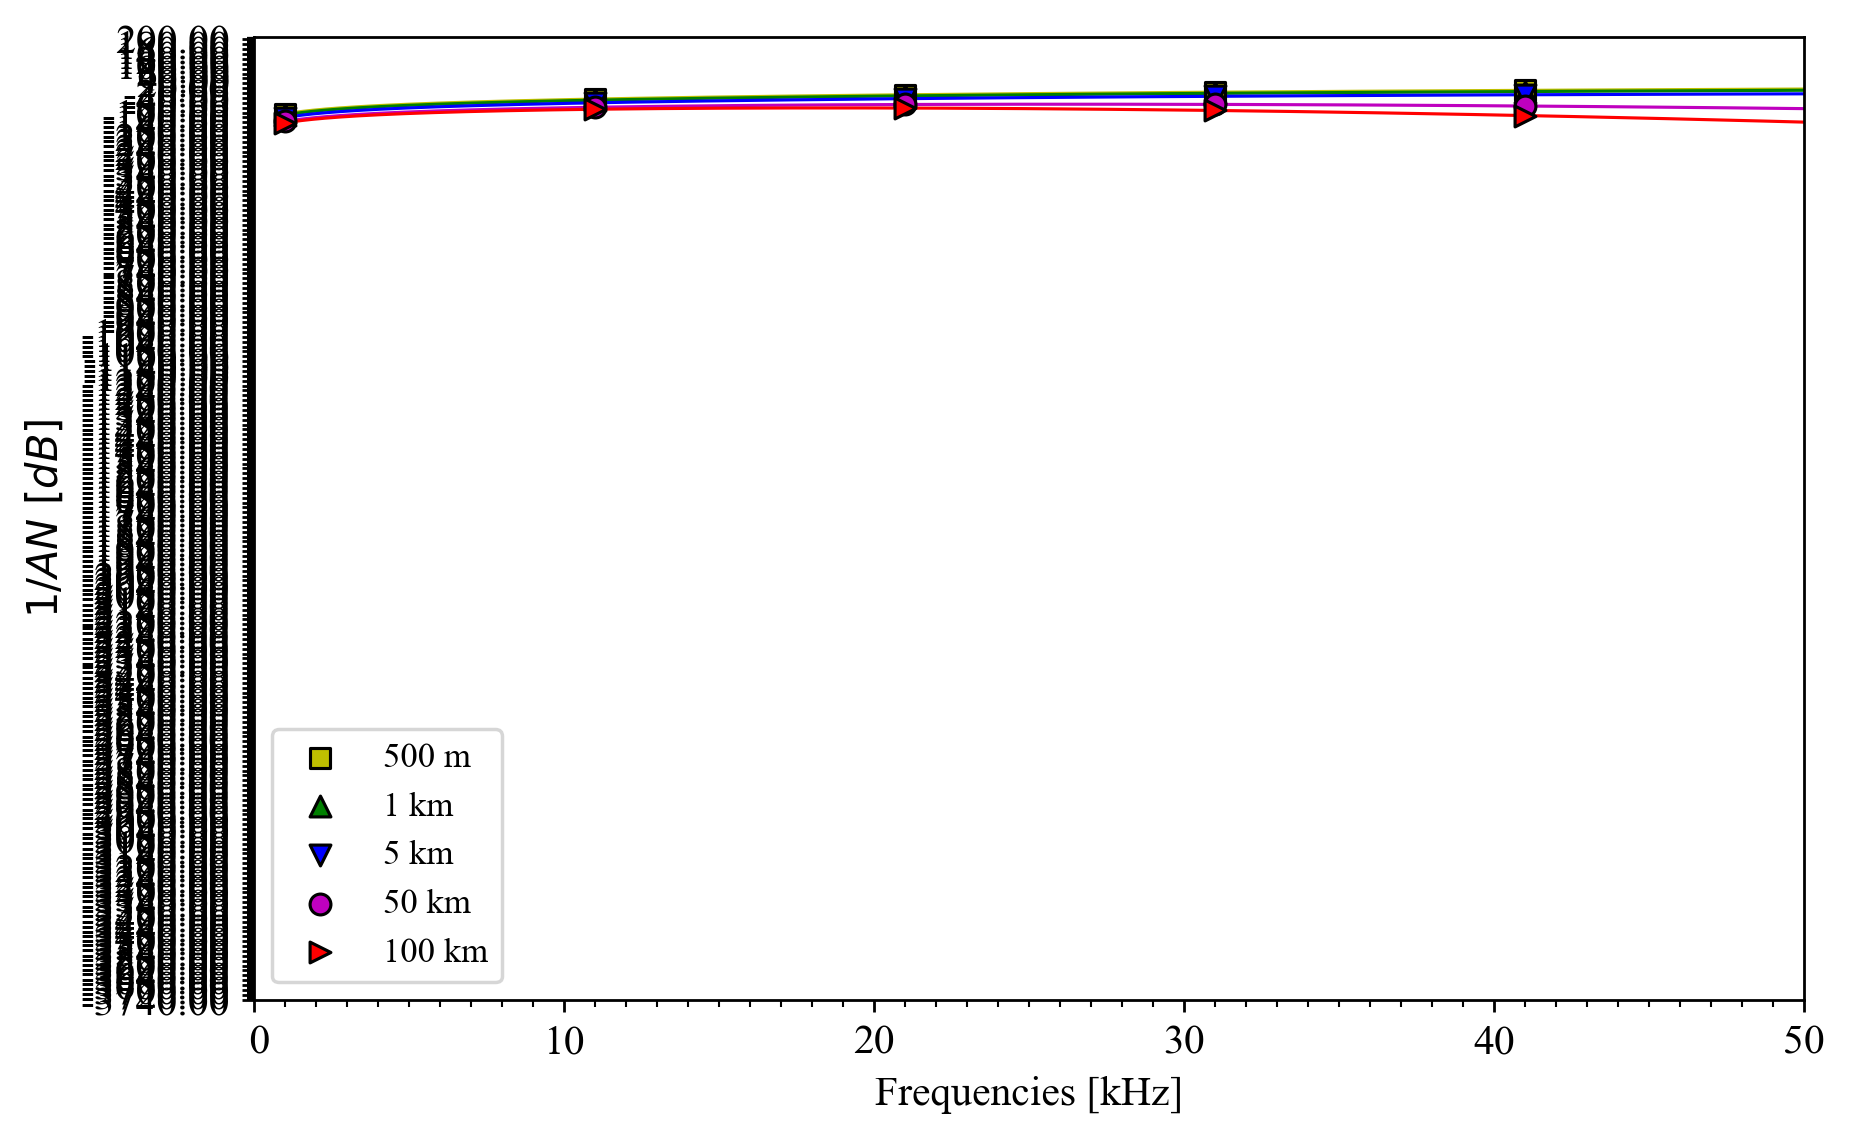

In [26]:
# Terhadap Jarak

frequencies = np.arange(1, 300, 0.01)
labels = ['500 m', '1 km', '5 km', '50 km', '100 km']
values = [500, 1000, 5000, 50000, 100000]
AN_data = {}
FONTSIZE = 12
count = 0

for label in labels:
    AN_data[label] = []
    for f in frequencies:
        n_th = thermal_noise(f)
        n_t = turbulence_noise(f)
        n_w = wind_noise(f, w)
        n_s = ship_noise(f, sh)

        n_total = n_th + n_w + n_t + n_s

        # n_total = 10**(n_th/10) + 10**(n_t/10) + 10**(n_w/10) + 10**(n_s/10)

        AN_data[label].append(
            -n_total - attenuation_dB(1000, values[count],  f)
        )

    count += 1

# 500 m$f_{opt}=$$264.54\, kHz | 1/AN : 29.32$
# 1 km$f_{opt}=$$187.01\, kHz | 1/AN : 15.17$
# 5 km$f_{opt}=$$83.56\, kHz | 1/AN : -17.73$
# 50 km$f_{opt}=$$26.33\, kHz | 1/AN : -65.67$
# 100 km$f_{opt}=$$18.58\, kHz | 1/AN : -80.97$

f_opts = []
for label in labels:
    AN_max = np.array(AN_data[label])
    f_opts.append(
        [frequencies[np.argmax(AN_max)], AN_max[np.argmax(AN_max)]]
    )

count = 0
for f_opt in f_opts:
    text = f"{labels[count]}" + r"$f_{opt}=$" + f"${f_opt[0]:.2f}\, kHz | 1/AN : {f_opt[1]:.2f}$"
    print(text)
    # ax.text(x=f_opt[0], y=f_opt[1] + 10, s=text, zorder=2, fontsize=FONTSIZE, ha="center", va="center")
    # ax.scatter(f_opt[0], y=f_opt[1], color=colors[count],     linewidth=0.9, label=labels[count], edgecolor='k', marker=markers[count])
    count += 1
fig, ax = plt.subplots(figsize=(8,5), dpi=250)

hop = 10000

colors = ['y', 'g', 'b', 'm', 'r', 'k', 'navy', 'maroon']
markers = ['s', '^', 'v', 'o', '>', '<', 'X', 'D']
linestyles = ['solid', 'solid', 'solid', 'solid', 'solid', '<', 'X', 'D']

count = 0
hop = 1000


for label in labels:
    ax.plot(frequencies          , AN_data[label]          , linestyle="solid", color=colors[count],     linewidth=0.9, zorder=1)
    ax.scatter(frequencies[::hop], AN_data[label][::hop]                   , color=colors[count],     linewidth=0.9, label=labels[count], edgecolor='k', marker=markers[count], zorder=2)
    count += 1

count = 0
    
ax.set_ylabel(r"$1/AN  \,\, [dB]$", fontsize=FONTSIZE)
ax.set_xlabel(r"Frequencies [kHz]", fontsize=FONTSIZE)


ax.set_xlim([0, 50])
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_formatter('{x:.2f}')
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter('{x:2.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.xaxis.set_tick_params(labelsize=FONTSIZE)
ax.yaxis.set_tick_params(labelsize=FONTSIZE)
ax.legend(fontsize=FONTSIZE-2)
plt.show()


500 m$f_{opt}=$$184.30\, kHz | 1/AN : 14.76$
1 km$f_{opt}=$$187.00\, kHz | 1/AN : 15.17$
5 km$f_{opt}=$$210.40\, kHz | 1/AN : 18.45$
50 km$f_{opt}=$$790.70\, kHz | 1/AN : 55.22$
100 km$f_{opt}=$$3441.50\, kHz | 1/AN : 96.09$


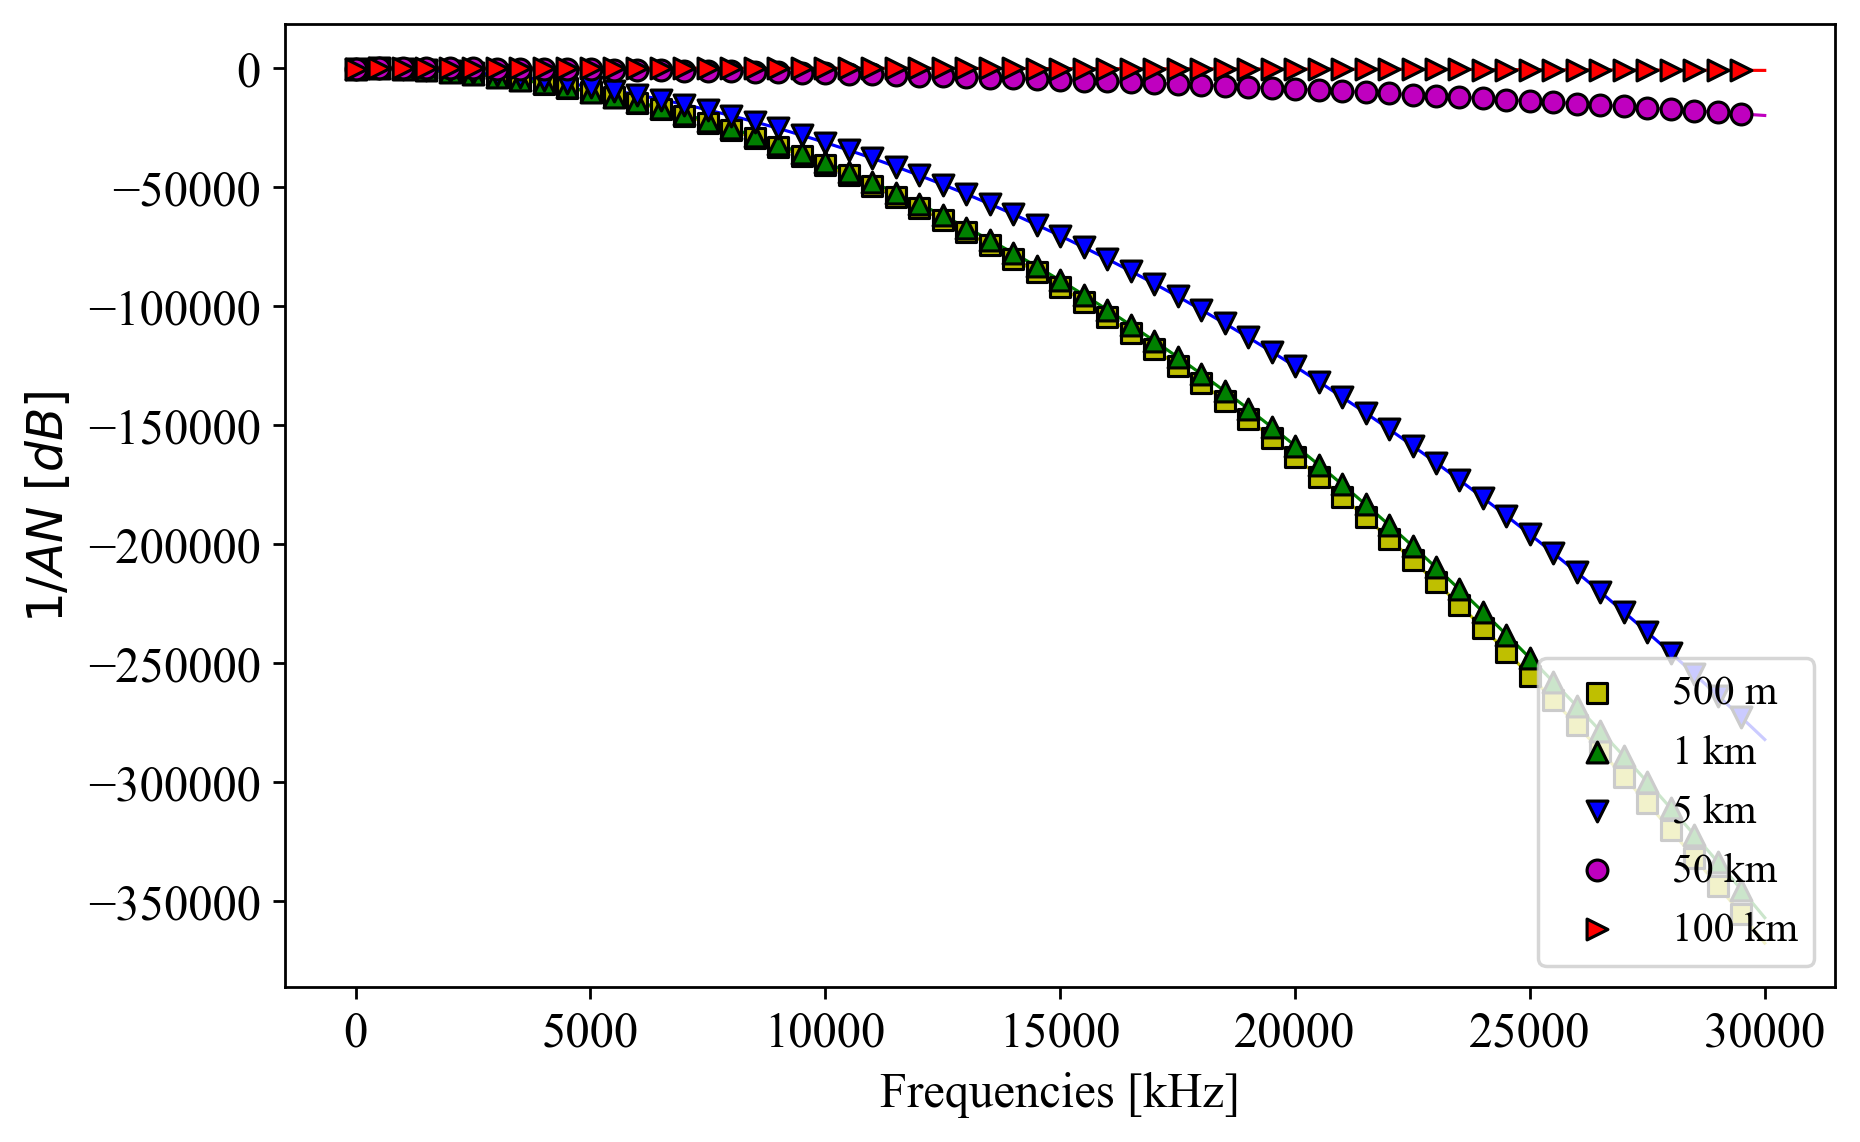

In [27]:
# Terhadap Kedalaman

# frequencies = np.arange(1, 50, 0.01)
frequencies = np.arange(1, 30000, 0.1)
labels = ['500 m', '1 km', '5 km', '50 km', '100 km']
values = [500, 1000, 5000, 50000, 100000]
AN_data = {}
FONTSIZE = 14
count = 0

for label in labels:
    AN_data[label] = []
    for f in frequencies:
        n_th = thermal_noise(f)
        n_t = turbulence_noise(f)
        n_w = wind_noise(f, w)
        n_s = ship_noise(f, sh)

        n_total = n_th + n_t + n_w + n_s

        # n_total = 10**(n_th/10) + 10**(n_t/10) + 10**(n_w/10) + 10**(n_s/10)

        AN_data[label].append(
            -n_total - attenuation_dB(values[count],  1000, f)
        )

    count += 1


fig, ax = plt.subplots(figsize=(8,5), dpi=250)

hop = 10000

colors = ['y', 'g', 'b', 'm', 'r', 'k', 'navy', 'maroon']
markers = ['s', '^', 'v', 'o', '>', '<', 'X', 'D']
linestyles = ['solid', 'solid', 'solid', 'solid', 'solid', '<', 'X', 'D']

count = 0
hop = 5000


for label in labels:
    ax.plot(frequencies          , AN_data[label]          , linestyle="solid", color=colors[count],     linewidth=0.9, zorder=1)
    ax.scatter(frequencies[::hop], AN_data[label][::hop]                   , color=colors[count],     linewidth=0.9, label=labels[count], edgecolor='k', marker=markers[count], zorder=2)
    count += 1

f_opts = []
for label in labels:
    AN_max = np.array(AN_data[label])
    f_opts.append(
        [frequencies[np.argmax(AN_max)], AN_max[np.argmax(AN_max)]]
    )

count = 0
for f_opt in f_opts:
    text = f"{labels[count]}" + r"$f_{opt}=$" + f"${f_opt[0]:.2f}\, kHz | 1/AN : {f_opt[1]:.2f}$"
    print(text)
    # ax.text(x=f_opt[0], y=f_opt[1] + 10, s=text, zorder=2, fontsize=FONTSIZE, ha="center", va="center")
    # ax.scatter(f_opt[0], y=f_opt[1], color=colors[count],     linewidth=0.9, label=labels[count], edgecolor='k', marker=markers[count])
    count += 1
    
ax.set_ylabel(r"$1/AN  \,\, [dB]$", fontsize=FONTSIZE)
ax.set_xlabel(r"Frequencies [kHz]", fontsize=FONTSIZE)


# ax.yaxis.set_major_locator(MultipleLocator(20))
# ax.yaxis.set_major_formatter('{x:.2f}')
# ax.yaxis.set_minor_locator(MultipleLocator(4))
# ax.xaxis.set_major_locator(MultipleLocator(50))
# ax.xaxis.set_major_formatter('{x:2.0f}')
# ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.legend()

ax.xaxis.set_tick_params(labelsize=FONTSIZE)
ax.yaxis.set_tick_params(labelsize=FONTSIZE)
ax.legend(loc= "lower right",fontsize=FONTSIZE-2)
plt.show()


# P_0 vs SNR

Locator attempting to generate 25848 ticks ([-493380.0, ..., 23560.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25848 ticks ([-493380.0, ..., 23560.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 258464 ticks ([-493372.0, ..., 23554.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25848 ticks ([-493380.0, ..., 23560.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25848 ticks ([-493380.0, ..., 23560.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 258464 ticks ([-493372.0, ..., 23554.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25848 ticks ([-493380.0, ..., 23560.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 25848 ticks ([-493380.0, ..., 23560.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 258464 ticks ([-493372.0, ..., 23554.0]), which exceeds Locator.MAXTICKS (1000)

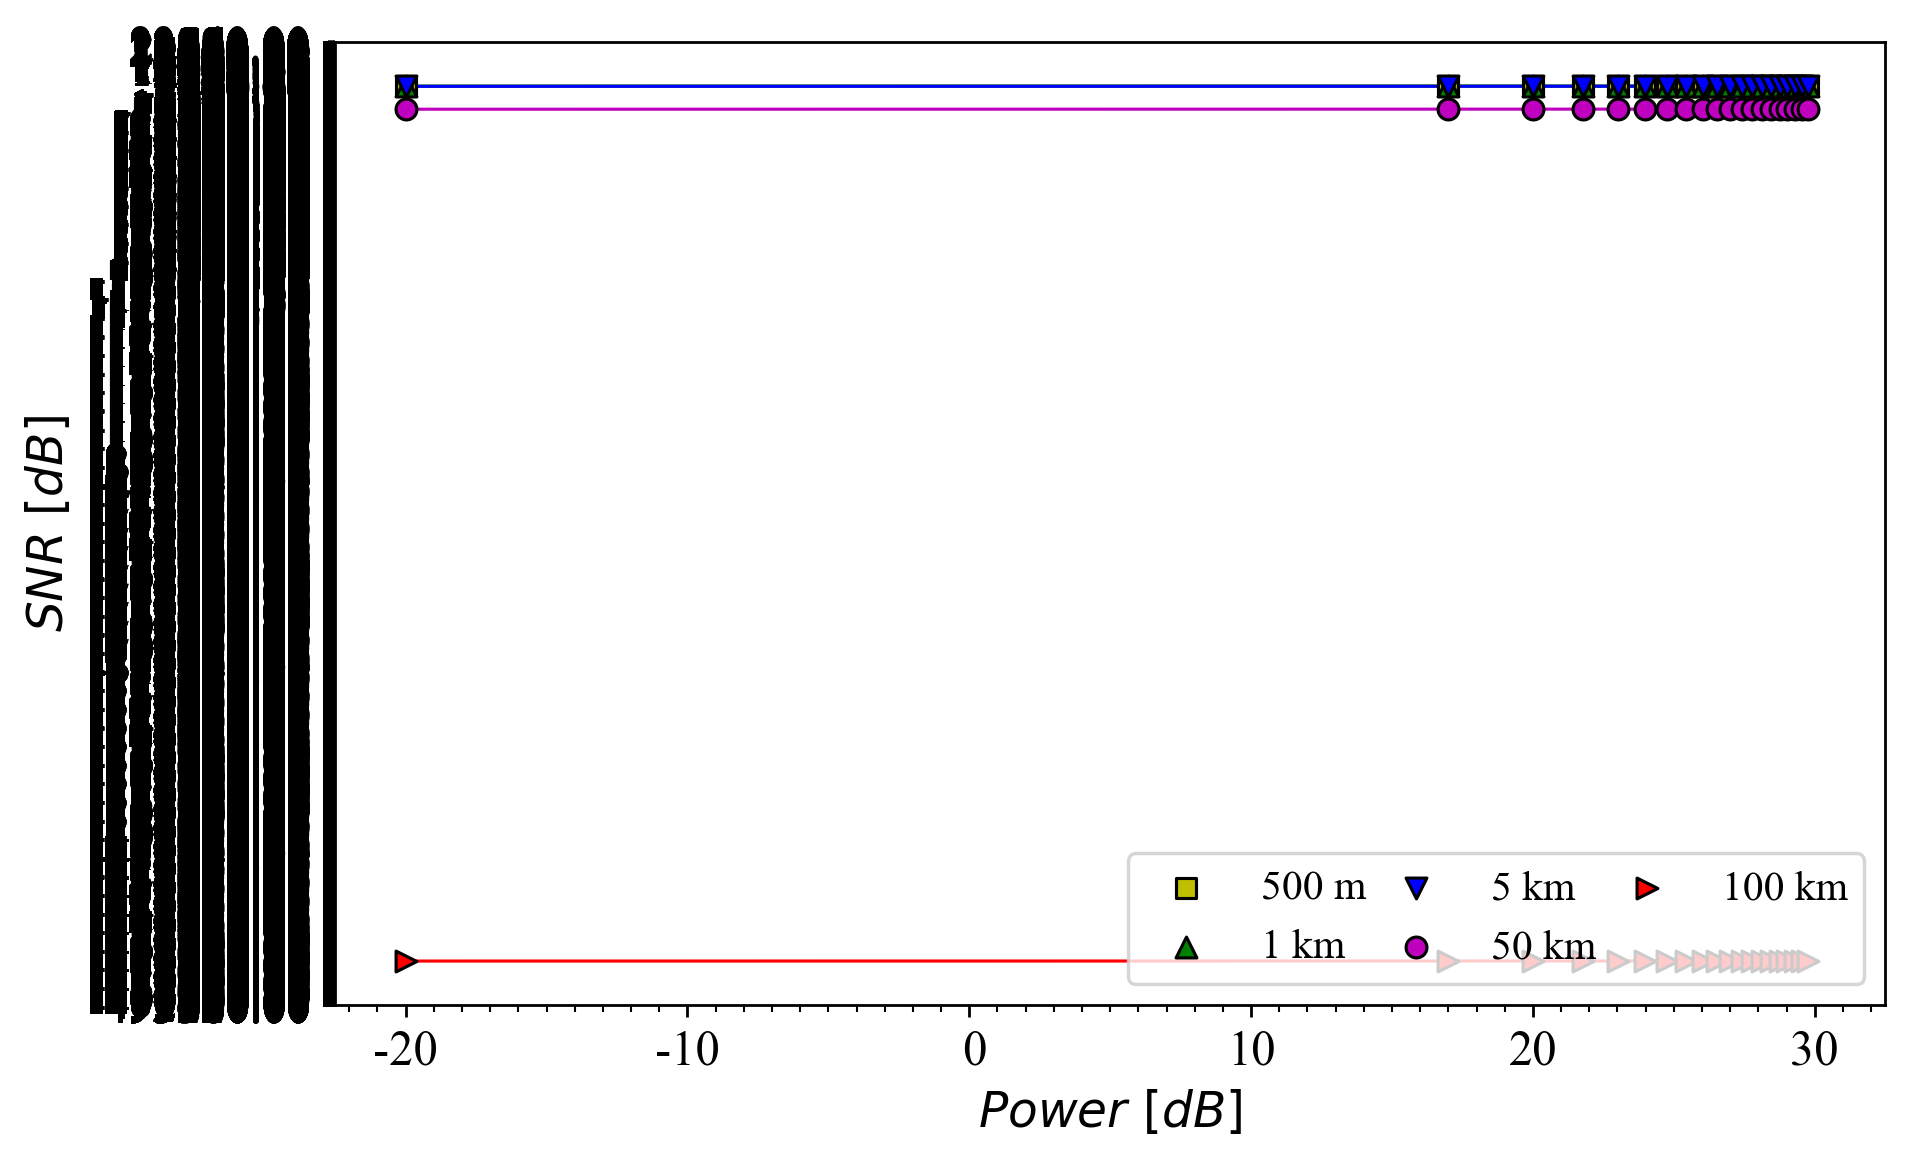

In [13]:
# Terhadap Kedalaman

powers = np.arange(0.01, 1000, 0.01)
powers_dB = 10 * np.log10(powers)
labels = ['500 m', '1 km', '5 km', '50 km', '100 km']
values = [500, 1000, 5000, 50000, 100000]
SNR_data = {}
FONTSIZE = 14
count = 0

for label in labels:
    SNR_data[label] = []
    f = f_opts[count][0]
    d = values[count]
    for power in powers_dB:
        n_th = thermal_noise(f)
        n_t = turbulence_noise(f)
        n_w = wind_noise(f, w)
        n_s = ship_noise(f, sh)
        n_total = 10**(n_th/10) + 10**(n_t/10) + 10**(n_w/10) + 10**(n_s/10)

        n_total = n_th + n_w + n_t + n_s

        # n_total = 10**(n_th/10) + 10**(n_t/10) + 10**(n_w/10) + 10**(n_s/10)
        SNR_data[label].append(
            power - n_total - attenuation_dB(1000,  d, f)
        )

    count += 1


fig, ax = plt.subplots(figsize=(8,5), dpi=250)

hop = 10000

colors = ['y', 'g', 'b', 'm', 'r', 'k', 'navy', 'maroon']
markers = ['s', '^', 'v', 'o', '>', '<', 'X', 'D']
linestyles = ['solid', 'solid', 'solid', 'solid', 'solid', '<', 'X', 'D']

count = 0
hop = 5000


for label in labels:
    ax.plot(powers_dB          , SNR_data[label]          , linestyle="solid", color=colors[count],     linewidth=0.9, zorder=1)
    ax.scatter(powers_dB[::hop], SNR_data[label][::hop]                   , color=colors[count],     linewidth=0.9, label=labels[count], edgecolor='k', marker=markers[count], zorder=2)
    count += 1

count = 0
for f_opt in f_opts:
    text = r"$f_{opt}=$" + f"${f_opt[0]:.2f}\, kHz$"
    # ax.text(x=f_opt[0], y=f_opt[1] + 10, s=text, zorder=2, fontsize=FONTSIZE, ha="center", va="center")
    # ax.scatter(f_opt[0], y=f_opt[1], color=colors[count],     linewidth=0.9, label=labels[count], edgecolor='k', marker=markers[count])
    count += 1
    
ax.set_ylabel(r"$SNR  \,\, [dB]$", fontsize=FONTSIZE)
ax.set_xlabel(r"$Power \,\, [dB]$", fontsize=FONTSIZE)


ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_major_formatter('{x:.2f}')
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter('{x:2.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.legend(fontsize=FONTSIZE-2)

ax.xaxis.set_tick_params(labelsize=FONTSIZE)
ax.yaxis.set_tick_params(labelsize=FONTSIZE)
ax.legend(fontsize=12, ncol=3, labelspacing=0.5, columnspacing = 0.2, loc="lower right")
plt.show()


In [14]:
f = 19.8
n_th = thermal_noise(f)
n_t = turbulence_noise(f)
n_w = wind_noise(f, 0)
n_s = ship_noise(f, 0)
n_total = 10**(n_th/10) + 10**(n_t/10) + 10**(n_w/10) + 10**(n_s/10)
n_total = 10 * np.log10(n_total)
att = attenuation(1000, 10000, f)
att = 10 * np.log10(att)
-0.32-n_total - att

30.008851013763785

In [15]:
10**(n_total/10)

247.9067305491086

In [16]:
n_total

23.942883178152524

In [17]:
att

-54.27173419191631

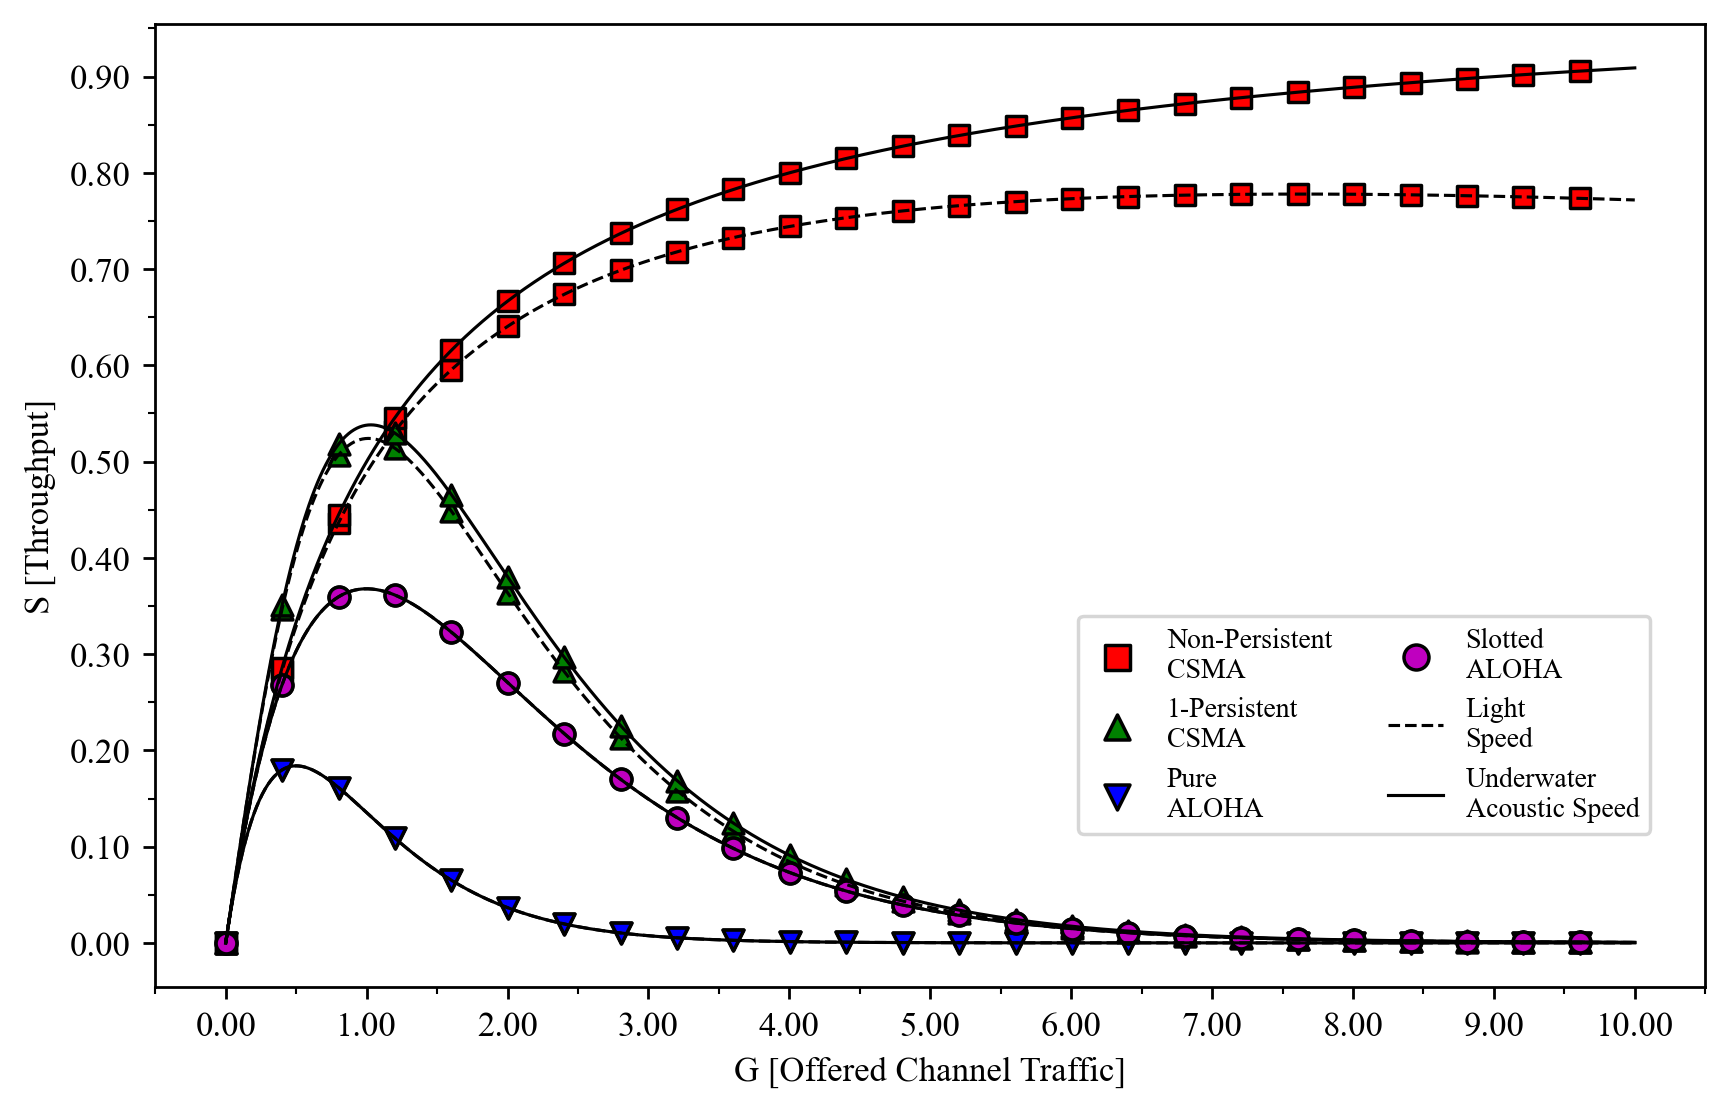

Ratio delay underwater : 0.014923304940768715 | Ratio delay ideal : 3.3333333333333333e-06


In [18]:
DEPTHS = [i for i in range(100, 10000, 50)]
G = np.linspace(0, 10, 1000)
PROTOCOLS = ["non-persistent", "1-persistent", "aloha", "slotted-aloha"]
labels = ["Non-Persistent\nCSMA", "1-Persistent\nCSMA", "Pure\nALOHA", "Slotted\nALOHA"]
colors = ['r', 'g', 'b', 'm', 'y', 'c', 'navy', 'maroon']
markers = ['s', '^', 'v', 'o', '>', '<', 'X', 'D']
fig, ax = plt.subplots(figsize=(8,5), dpi=250)
depth_protocol = {}
depth_protocol2 = {}
for protocol in PROTOCOLS:
    depth_protocol[protocol] = []
    depth_protocol2[protocol] = []
    for kc in G:
        a = ratio_delay(1000, 1000, 500)
        depth_protocol[protocol].append(throughput(a, protocol, kc))
        a2 = ratio_delay(1000, 1000, 500, True)
        depth_protocol2[protocol].append(throughput(a2, protocol, kc))

count = 0
hop = 40
for protocol in PROTOCOLS:
    ax.plot(G, depth_protocol[protocol] ,linestyle="--", color='k', linewidth=0.9)
    ax.plot(G, depth_protocol2[protocol]               , color='k', linewidth=0.9)
    ax.scatter(G[::hop], depth_protocol[protocol][::hop] , label=labels[count], marker=markers[count], edgecolor='k', color=colors[count])
    ax.scatter(G[::hop], depth_protocol2[protocol][::hop]                     , marker=markers[count], edgecolor='k', color=colors[count])
    count += 1

ax.plot(0, 0,linestyle="--", color='k', linewidth=0.9, label="Light\nSpeed")
ax.plot(0, 0               , color='k', linewidth=0.9, label="Underwater\nAcoustic Speed")
ax.set_ylabel(r"S [Throughput]", fontsize=10)
ax.set_xlabel(r"G [Offered Channel Traffic]", fontsize=10)
# ax.set_title(r"Protocol Comparison with $\zeta_{uw}=0.015$ and $\zeta_{c}=3.33 \times 10^{-6}$")

ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter('{x:.2f}')
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter('{x:.2f}')
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    
ax.legend(loc='upper center', bbox_to_anchor=(0.78, 0.4),
              fancybox=True, shadow=False, ncol=2, markerscale=1.2, fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.show()
print(f"Ratio delay underwater : {a} | Ratio delay ideal : {a2}")

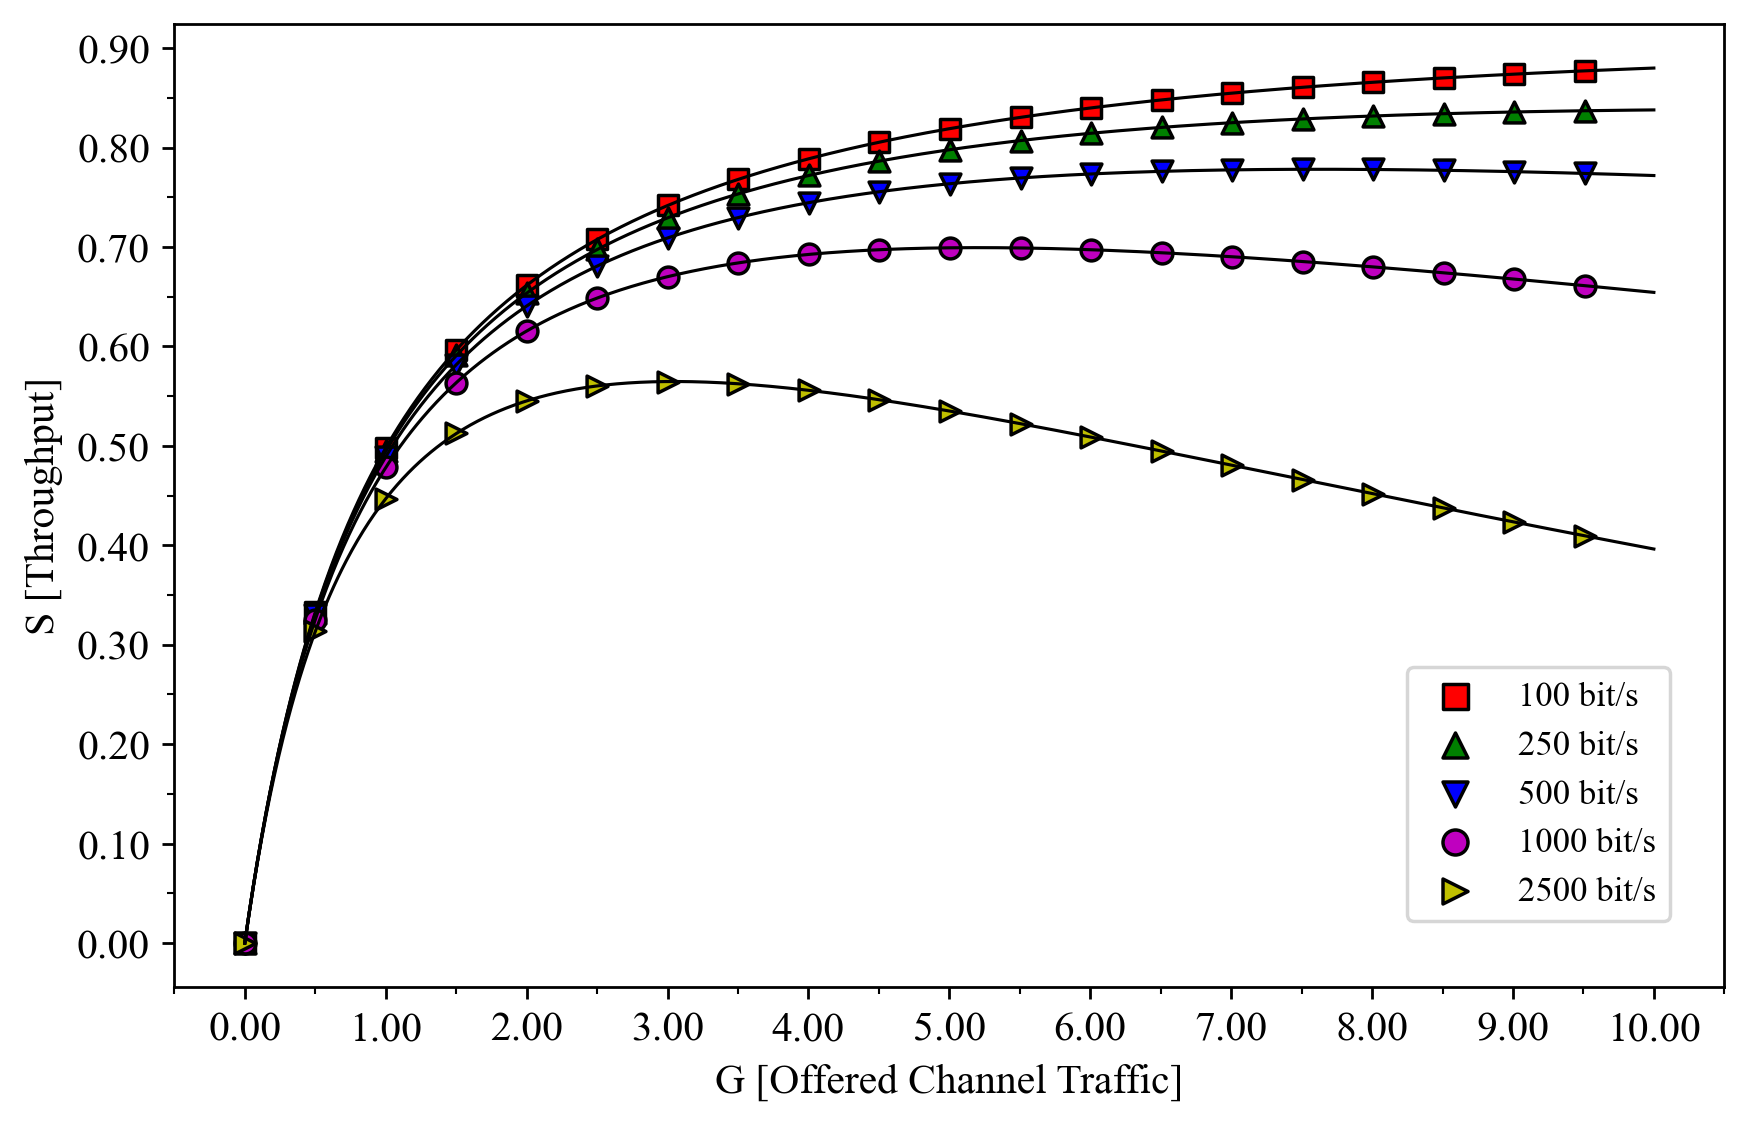

Ratio delay underwater : 0.07461652470384356 | Ratio delay ideal : 3.3333333333333333e-06


In [19]:
BPS = [100, 250, 500, 1000, 2500]
G = np.linspace(0, 10, 1000)

colors = ['r', 'g', 'b', 'm', 'y', 'c', 'navy', 'maroon']
markers = ['s', '^', 'v', 'o', '>', '<', 'X', 'D']
fig, ax = plt.subplots(figsize=(8,5), dpi=250)
data = []

hop = 50
count = 0
non_persistent_bps = {}

for bps in BPS:
    a = ratio_delay(1000, 1000, bps, ideal=False)
    non_persistent_bps[f"{bps} bit/s"] = []
    for kc in G:
        non_persistent_bps[f"{bps} bit/s"].append(
            throughput(a, "non-persistent", kc)
        )

for bps in non_persistent_bps.keys():
    ax.plot     (G, non_persistent_bps[bps]                     , color='k'     , linewidth=0.9         )
    ax.scatter  (G[::hop], non_persistent_bps[bps][::hop]       , marker=markers[count] , edgecolor='k' , color=colors[count]   , label=f"{bps}")
    count += 1

ax.set_ylabel(r"S [Throughput]", fontsize=12)
ax.set_xlabel(r"G [Offered Channel Traffic]", fontsize=12)
# ax.set_title(r"Protocol Comparison with $\zeta_{uw}=0.015$ and $\zeta_{c}=3.33 \times 10^{-6}$")

ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter('{x:.2f}')
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter('{x:.2f}')
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper center', bbox_to_anchor=(0.88, 0.35),
              fancybox=True, shadow=False, ncol=1, markerscale=1.2, fontsize=10)

plt.show()
print(f"Ratio delay underwater : {a} | Ratio delay ideal : {a2}")